# Выбор локации для скважины

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

from numpy.random import RandomState

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression 
from sklearn.dummy import DummyClassifier

from sklearn.metrics import (
    f1_score, 
    confusion_matrix, 
    roc_auc_score, 
    accuracy_score, 
    precision_score, 
    recall_score,
    mean_squared_error
)

## Загрузка и подготовка данных

Открываем файлы и проверяем данные

In [2]:
data0 = pd.read_csv('~/ya_praktikum_projects/datasets/P3_ml_well_location/geo_data_0.csv')
data1 = pd.read_csv('~/ya_praktikum_projects/datasets/P3_ml_well_location/geo_data_1.csv')
data2 = pd.read_csv('~/ya_praktikum_projects/datasets/P3_ml_well_location/geo_data_2.csv')
data = {0:data0, 1:data1, 2:data2}

In [3]:
for i in data:
    data[i].info()
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Nul

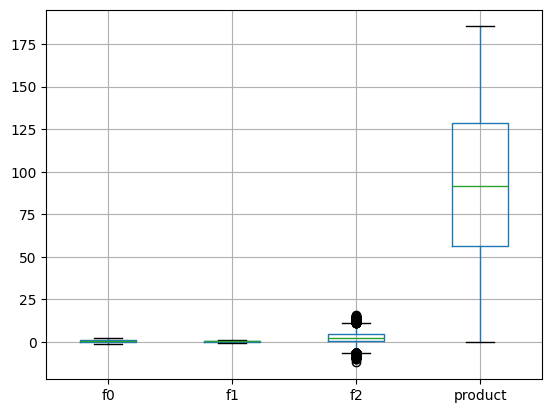

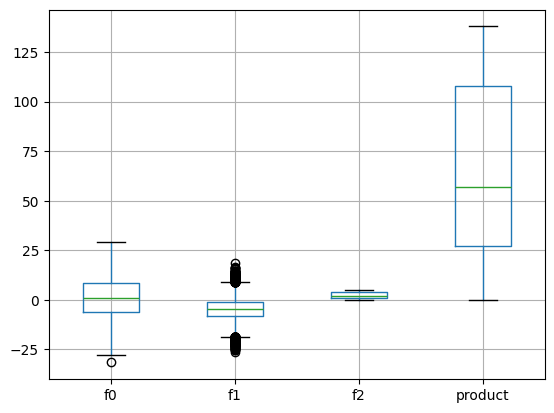

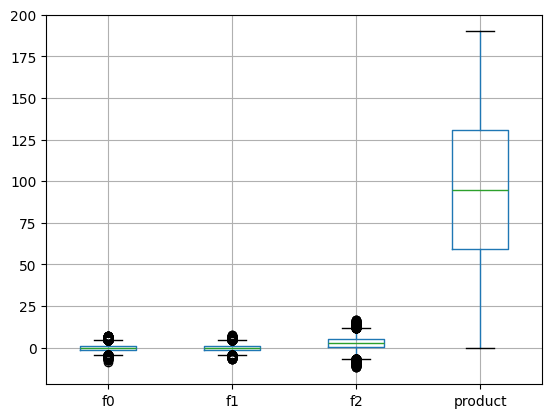

In [4]:
for i in data:
    data[i].boxplot()
    plt.show()
    print()

In [5]:
for i in data:
    display(data[i].sample(5))

,id,f0,f1,f2,product
74643,eteDi,-0.477830,0.897075,4.322769,116.456019
96200,E42gY,1.003198,0.194294,2.723947,73.305204
76022,37ZO8,1.090199,-0.418163,1.451585,127.571734
25576,yoitW,0.717137,0.413048,2.937433,154.056711
40137,tzsT6,0.896922,0.530580,3.741989,57.473453


,id,f0,f1,f2,product
84211,bvmPi,4.395401,-2.467560,1.004066,30.132364
85553,wEJ1p,-6.468613,-4.943223,4.994632,137.945408
16557,CsnUt,8.326185,1.639611,2.003657,53.906522
70507,3YRM3,8.956194,-0.347943,5.003987,134.766305
88514,RsJlk,5.984203,-4.302444,4.992437,134.766305


,id,f0,f1,f2,product
43136,47Q8h,-0.636740,-0.224414,1.435591,75.406894
66918,8ekwz,-2.528939,-1.226250,0.164199,77.058380
25814,zou9g,-0.621619,1.960252,2.246278,151.183661
20855,k0EGp,-0.396846,3.599622,-2.274443,137.978254
29399,Cr3Qp,0.838140,0.085784,6.880395,95.120272


Разбиваем данные на признаки и целевые признаки

In [6]:
features = {}
target = {}

In [7]:
for i in data:
    features[i] = data[i].drop(['product', 'id'], axis=1)
    target[i] = data[i]['product']

Пропуски в данных не выявлены, аномальных значений также нет. Данные разбиты на признаки

## Обучение и проверка модели

Разбиваем данные на обучающую и валидационную выборки:

In [8]:
features_train = {}
features_valid = {}
target_train = {}
target_valid = {}

In [9]:
for i in data:
    features_train[i], features_valid[i], target_train[i], target_valid[i] = train_test_split(
        features[i], 
        target[i], 
        test_size=.25, 
        random_state=111,
    )

In [10]:
for i in data:
    print(features_train[i].shape)
    print(features_valid[i].shape)
    print(target_train[i].shape)
    print(target_valid[i].shape)

(75000, 3)
(25000, 3)
(75000,)
(25000,)
(75000, 3)
(25000, 3)
(75000,)
(25000,)
(75000, 3)
(25000, 3)
(75000,)
(25000,)


Обучаем модель линейной регресси для предсказания целевого признака на обучающей выборке, считаем предсказанный средний запас сырья для каждого региона и rmse моделей:

In [11]:
predicted_valid = {}
rmse = {}

In [12]:
for i in data:
    model = LinearRegression()
    model.fit(features_train[i], target_train[i])
    predicted_valid[i] = model.predict(features_valid[i])
    rmse[i] = mean_squared_error(target_valid[i], predicted_valid[i]) ** .5
    print('mean', i, ':', predicted_valid[i].mean())
    print('rmse', i, ':', rmse[i])

mean 0 : 92.29078145399956
rmse 0 : 37.94937084971467
mean 1 : 68.7140587425328
rmse 1 : 0.8887519060864156
mean 2 : 95.10177611271679
rmse 2 : 39.94773136808895


У регионов 0 и 2 средние запасы больше, но выше ошибки модели, у региона 1 ошибки модели минимальны, но ниже средние запасы

## Подготовка к расчёту прибыли

Записываем ключевые параметры для расчета прибыли

In [13]:
ALL_WELL_COUNT = 500
GOOD_WELL_COUNT = 200
BUDGET = 10 ** 10
INCOME_PER_UNIT = 450000

Расчитываем объем нефти в скважине для безубыточной разработки

In [14]:
profit_volume = BUDGET / GOOD_WELL_COUNT / INCOME_PER_UNIT
profit_volume

111.11111111111111

Получившийся объем меньше среднего в каждом регионе, но сопоставим с объемом в 0 и 2 регионе

## Расчёт прибыли и рисков 

Функция расчета прибыли в регионе:

In [15]:
def profit(target, probabilities, count):
    return INCOME_PER_UNIT * target[probabilities.sort_values(ascending=False).index].head(count).sum() - BUDGET

Применяем бутстреп и находим среднюю прибыль, 95%-й доверительный интервал и риск убытков:

In [16]:
state = RandomState(111)
for i in data:
    values = []
    for k in range(1000):
        target_subsample = target_valid[i].reset_index(drop=True).sample(
            ALL_WELL_COUNT, replace=True, random_state=state
        )
        predicted_subsumple = pd.Series(predicted_valid[i])[target_subsample.index]
        values.append(profit(target_subsample, predicted_subsumple, GOOD_WELL_COUNT))
    values = pd.Series(values)
    print('Регион', i, 'среднее', values.mean())
    print('Регион', i, 'Доверительный интервал', values.quantile(q=0.025), ':', values.quantile(q=0.975))
    print('Регион', i, 'Риск убытков', len(values[values < 0]) / len(values) * 100, '%')


Регион 0 среднее 369943542.1089652
Регион 0 Доверительный интервал -144382355.46106046 : 895445097.6783676
Регион 0 Риск убытков 9.0 %
Регион 1 среднее 486734441.26289296
Регион 1 Доверительный интервал 60938081.65642787 : 900858193.5809848
Регион 1 Риск убытков 1.2 %
Регион 2 среднее 393037811.37232447
Регион 2 Доверительный интервал -165150125.8508944 : 926889687.1021069
Регион 2 Риск убытков 8.3 %


Средняя прибыль выше, доверительный интервал меньше, а также наименьший риск убытков у региона 1. Исходя из найденных значений предлагается 1 регион для разработки.